In [15]:
from pyspark.sql import SQLContext
from handyspark import *
from pyspark.sql import functions as sf
from matplotlib import pyplot as plt
from pyspark.sql.functions import col, avg
import pandas as pd
from pyspark.ml.feature import VectorAssembler
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.sql import Row
import pyspark

In [16]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.79:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.79:7077 appName=spark>

## Load Average Profile csv

In [17]:
base_path = "/media/iitp/disk/smart-meters-in-london/"
sqlcontext = SQLContext(sc)
#avg_power_df = sqlcontext.read.format("com.databricks.spark.csv").load(base_path+"avg.csv/*")#csv(base_path+"avg.csv/",header=True,inferSchema=True)
avg_power_df = sqlcontext.read.csv(base_path+"avg.csv",header=True,inferSchema=True).cache()
avg_power_df.count()

1132

## Adding "`" to properly  select OW Analysis exception

### just to be clear, the reason for this is that the column name has a period in it. Spark is in general a little buggy as far as properly supporting backticks throughout codebase, but in this case they're fine

In [20]:
avg_power_df = avg_power_df.drop("_c0")
avg_power_df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- 00.5: double (nullable = true)
 |-- 01.0: double (nullable = true)
 |-- 01.5: double (nullable = true)
 |-- 02.0: double (nullable = true)
 |-- 02.5: double (nullable = true)
 |-- 03.0: double (nullable = true)
 |-- 03.5: double (nullable = true)
 |-- 04.0: double (nullable = true)
 |-- 04.5: double (nullable = true)
 |-- 05.0: double (nullable = true)
 |-- 05.5: double (nullable = true)
 |-- 06.0: double (nullable = true)
 |-- 06.5: double (nullable = true)
 |-- 07.0: double (nullable = true)
 |-- 07.5: double (nullable = true)
 |-- 08.0: double (nullable = true)
 |-- 08.5: double (nullable = true)
 |-- 09.0: double (nullable = true)
 |-- 09.5: double (nullable = true)
 |-- 10.0: double (nullable = true)
 |-- 10.5: double (nullable = true)
 |-- 11.0: double (nullable = true)
 |-- 11.5: double (nullable = true)
 |-- 12.0: double (nullable = true)
 |-- 12.5: double (nullable = true)
 |-- 13.0: double (nullable = true)
 |-- 13.5: double (nul

In [21]:
old_Feature_cols = []
new_Feature_cols = []
for i in range(1,49):
    if i<20:
        old_Feature_cols.append("0"+str(i*0.5))
    else:
        old_Feature_cols.append(str(i*0.5))
    if i<10:
        new_Feature_cols.append("0"+str(i))
    else:
        new_Feature_cols.append(str(i))
        
for c,n in zip(old_Feature_cols,new_Feature_cols):
            avg_power_df=avg_power_df.withColumnRenamed(c,n)
# avg_power_df.printSchema()

###### TODO : Scaling Feature using MinMaxSacler or any other can be done

In [22]:
avg_house_data = avg_power_df
vecAssembler = VectorAssembler(inputCols=new_Feature_cols, outputCol="features")
df_kmeans = vecAssembler.transform(avg_power_df)
df_kmeans.take(1)

[Row(LCLid='MAC004532', 01=0.13003835616438347, 02=0.09133424657534243, 03=0.07035068493150697, 04=0.06200821917808219, 05=0.06033972602739724, 06=0.05762739726027397, 07=0.05654520547945206, 08=0.05367123287671235, 09=0.061284931506849306, 10=0.06993698630136988, 11=0.06897260246575344, 12=0.12627397260273968, 13=0.20795890383561655, 14=0.265358903561644, 15=0.3348849309589041, 16=0.34675890383561647, 17=0.3683643841095891, 18=0.3918246572602742, 19=0.35000274, 20=0.3374356164383561, 21=0.29219999999999996, 22=0.2754876717808219, 23=0.28872054767123284, 24=0.309638356438356, 25=0.3049835616438357, 26=0.32495890465753435, 27=0.3212958901369862, 28=0.3014712323287672, 29=0.2800410964383562, 30=0.2897506857534248, 31=0.27526301397260283, 32=0.29691232849315086, 33=0.2874219183561644, 34=0.29585479424657557, 35=0.31566849287671234, 36=0.44753424602739694, 37=0.528575343013699, 38=0.5268958904109587, 39=0.5637780819178081, 40=0.5590410958904107, 41=0.5081698638356165, 42=0.4999150671232874

## Chosing K

In [23]:
wsse = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(df_kmeans.select("features"))
    wsse[k] = model.computeCost(df_kmeans) 
    print(wsse[k])

1447.1216732373816
1167.8297617452288
812.6734845082943
619.6704023294478
528.3035662950114
484.34003289450936
466.98187675520956
431.27228023911954


Text(0, 0.5, 'cost')

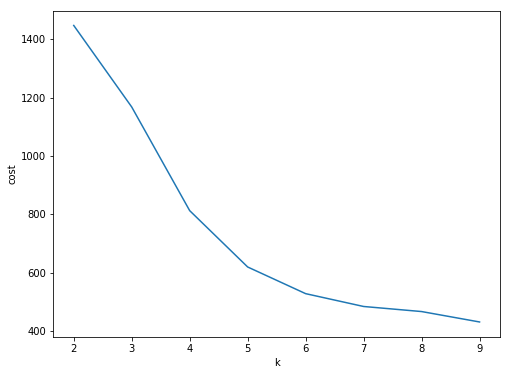

In [24]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),wsse[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')

### k = 7 from elbow method
### Train Model

In [37]:
k = 8
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans.select("features"))
centers = model.clusterCenters()

for i in range(len(centers)):
    centers[i] = centers[i].tolist()
# print("Cluster Centers: ")
# for center in centers:
#     print(center)
type(centers)

list

In [38]:
transformed = model.transform(df_kmeans)
transformed.select("prediction").show()

+----------+
|prediction|
+----------+
|         3|
|         6|
|         0|
|         0|
|         0|
|         1|
|         0|
|         3|
|         0|
|         0|
|         4|
|         3|
|         3|
|         0|
|         0|
|         0|
|         6|
|         4|
|         0|
|         4|
+----------+
only showing top 20 rows



In [39]:
cluster_centroid_rdd = sc.parallelize(centers)
cluster_centroid_rdd = cluster_centroid_rdd.flatMap(lambda x: Row(x))
cluster_centroid_rdd.collect()

[[0.0707214874861938,
  0.06330711467833319,
  0.05776469913361543,
  0.05415410600444668,
  0.05298214875134477,
  0.05164646059026034,
  0.049850649073370154,
  0.04955714695833035,
  0.049562655095746956,
  0.05082840134906401,
  0.053637631787276784,
  0.06087539983432547,
  0.06756534461880509,
  0.07751661048554828,
  0.08691897009395393,
  0.09594686222046904,
  0.09813619737072372,
  0.1002751129462813,
  0.09676722368572048,
  0.09385822276052502,
  0.09094774438643045,
  0.09084732124004875,
  0.09029913934662548,
  0.0915819048999498,
  0.09190644768342536,
  0.09334439502689514,
  0.09226940399627055,
  0.09091689737000654,
  0.08948951444954448,
  0.09027687010973251,
  0.09215362546725965,
  0.09586784765115111,
  0.10074939395825867,
  0.10956692963709382,
  0.11813024456071139,
  0.12641670371297425,
  0.13245824427167774,
  0.13769575413397406,
  0.14018424298285875,
  0.1403364555705371,
  0.1398130889994981,
  0.13840362187836186,
  0.13483564512371796,
  0.129234691

In [40]:
df_cluster_center=sqlcontext.createDataFrame(cluster_centroid_rdd,new_Feature_cols)
type(df_cluster_center)

pyspark.sql.dataframe.DataFrame

In [41]:
avg_house_data.show()

+---------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|    

If we don't assign color all plot will be of different color,
by putting ax=ax we are plotting on same graph,
if removed new graph below will be plotted.

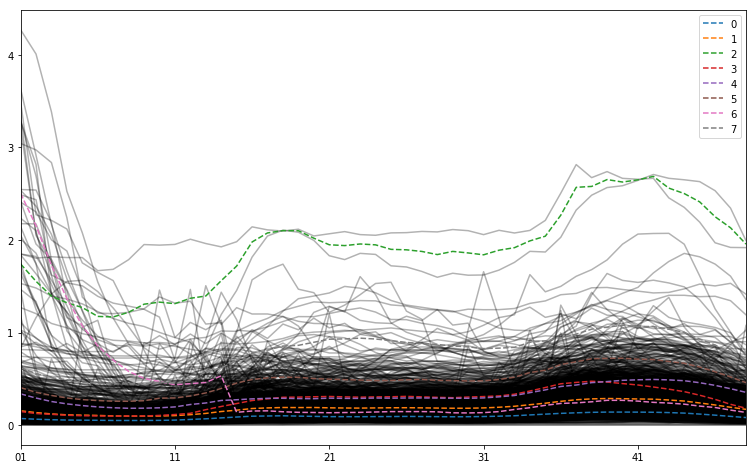

In [42]:
ax = avg_house_data.toPandas().set_index("LCLid").T.plot(figsize=(13,8), legend=False, color='black',alpha=0.3)
plot = df_cluster_center.toPandas().T.plot(ax=ax,alpha=1,style='--')

In [43]:
plot.get_figure().savefig(base_path+"cluster.png")